In [1]:
import pandas as pd

path = "./archive/pca_data.csv"

df = pd.read_csv(path, delimiter=",", quotechar='"')

print(df.head())

                                                tags  \
0  ['Mental Health', 'Health', 'Psychology', 'Sci...   
1  ['Health', 'Neuroscience', 'Mental Health', 'P...   
2  ['Brain', 'Health', 'Development', 'Psychology...   
3  ['Society', 'Mental Health', 'Health', 'Nonfic...   
4  ['Books', 'Entrepreneurship', 'Writing', 'Mark...   

                                          clean_text  \
0  photo josh riemer unsplash merry christmas hap...   
1  passionate synergy science technology provide ...   
2  youve heard havent phineas gage railroad worke...   
3  mentally young adult suffering covid come pain...   
4  turn popular blog series bestselling book thou...   

                                            PCA_text  
0  [0.39516538, 0.05899624, -0.021453878, -0.0111...  
1  [-0.21116884, 0.016064316, -0.0991472, 0.06884...  
2  [0.06188646, 0.008638164, -0.09875353, -0.0459...  
3  [0.1473181, -0.025129355, 0.022041861, 0.13384...  
4  [0.41400912, 0.13391365, 0.16083375, -0.136855..

In [2]:
import numpy as np
from ast import literal_eval


# Nettoyer la colonne "tags"
df["tags"] = df["tags"].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Extraire tous les tags uniques
unique_tags = set(tag.strip() for tags_list in df["tags"] for tag in tags_list)

# Afficher les résultats
print(f"Nombre total de tags uniques : {len(unique_tags)}")
print(unique_tags)


Nombre total de tags uniques : 24161
{'Middle East Strategy', 'Futureskills', 'The Lark', 'Api Gateway', 'Cerpen', 'Mlm Software', 'Our Human Family', 'Exchanges', 'Pytholabs', 'Ecto', 'Operational Excellence', 'Bad Poetry', '2nd Amendment', 'G4s', 'Phase 3 Project', 'Hell', 'Pro Choice', 'Decred', 'Spooky', 'Speech Pathology', 'Divvy', 'Peace Corps', 'Residual', 'Apple TV', 'Inversion', 'Amazon Fba', 'Ethereu', 'Azure Iot', 'Disruptive Technology', 'Storichain', 'Ayush Shekhar', 'Mastersprogram', 'Natural Language Processi', 'Google Cloud Platform', 'Agreement', 'Invarch', 'Pro', 'Grace Was', 'Hbo Max', 'Young Adult Fiction', 'Blogging Platform', 'Mockup', 'Bhagwad Gita', 'Kmd', 'Laptop Repair', 'Vnd', 'Back End Development', 'Scikit', 'Customer Support', 'Apachespark', 'Space', 'Hanukkah', 'Miro', 'Session', 'Baby Sleep', 'Pump And Dump', 'Blockchain News', 'Wikileaks', '80s Music', 'Bhagavad Gita', '9to5 Job', 'Struggles In Life', 'Advice and Opinion', 'Twitter Data', 'New Employee'

In [3]:
from json import loads
# ✅ Convertir la colonne PCA_text en une matrice numpy (plus sûr que vstack)
df["PCA_text"] = df["PCA_text"].apply(lambda x: loads(x) if isinstance(x, str) else x)

df_sample = df.sample(n=10000, random_state=42)

# Construire la matrice PCA en float32
X_pca = np.vstack(df_sample["PCA_text"].values).astype(np.float32)

print("Taille de la matrice PCA :", X_pca.shape)

Taille de la matrice PCA : (10000, 19)


In [4]:
print(X_pca.dtype)

float32


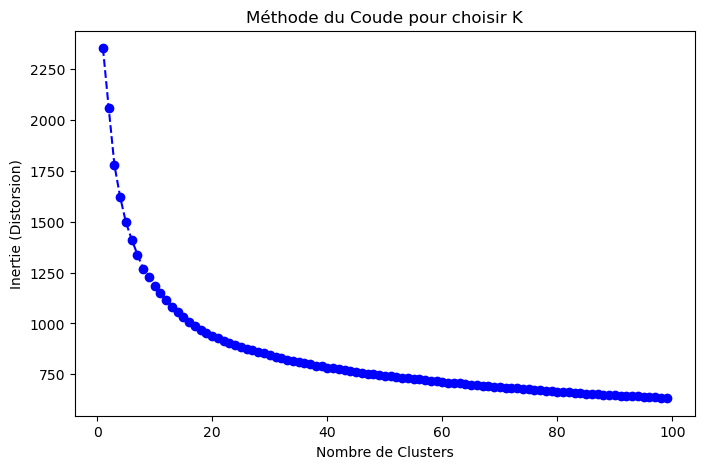

In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
os.environ["OMP_NUM_THREADS"] = "4"  # Limiter à 4 threads
from sklearn.cluster import KMeans

#Méthode du coude pour trouver le nombre de cluster optimisé

# Appliquer K-Means pour plusieurs valeurs de k
distortions = []

for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    distortions.append(kmeans.inertia_)  # Inertie = somme des distances au centre

# Tracer la courbe d'inertie
plt.figure(figsize=(8, 5))
plt.plot(range(1, 100), distortions, marker='o', linestyle='--', color='b')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie (Distorsion)')
plt.title("Méthode du Coude pour choisir K")
plt.show()


Nombre optimal de clusters : 3


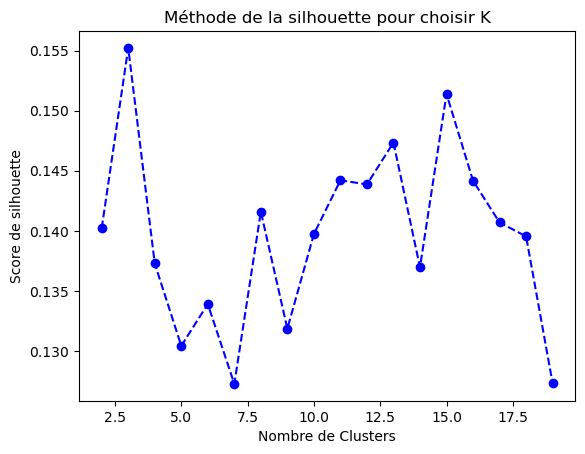

In [6]:
from sklearn.metrics import silhouette_score
silhouette_scores = []

#méthode silhouette de 2 à 20 car réduit grâce à la méthode du coude
for k in range(2, 20):  # On teste plusieurs valeurs de k
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Trouver le k optimal
optimal_k = np.argmax(silhouette_scores) + 2  # +2 car on commence à k=2
print(f"Nombre optimal de clusters : {optimal_k}")

plt.plot(range(2, 20), silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de silhouette')
plt.title("Méthode de la silhouette pour choisir K")
plt.show()

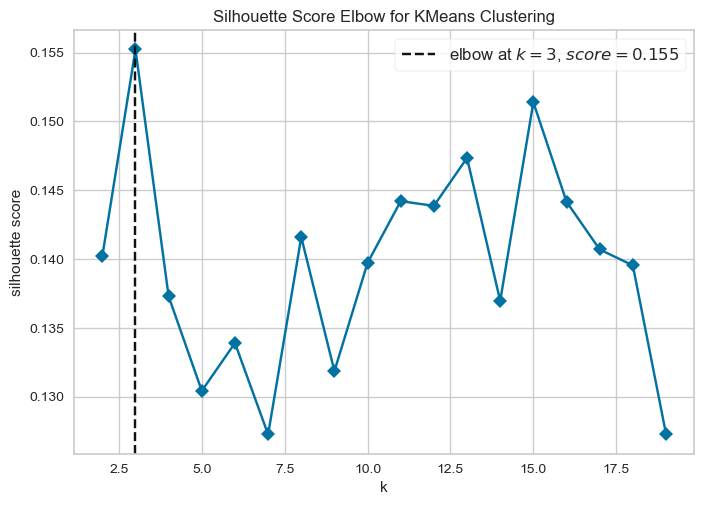

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [7]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 20), metric='silhouette', timings=False)

visualizer.fit(X_pca)
visualizer.show()

In [8]:
from sklearn.metrics import davies_bouldin_score
scores_db = []
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = davies_bouldin_score(X_pca, labels)
    scores_db.append(score)

optimal_k_db = np.argmin(scores_db) + 2  # +5 car on commence à k=5
print(f"Optimal K selon Davies-Bouldin: {optimal_k_db}")

Optimal K selon Davies-Bouldin: 3


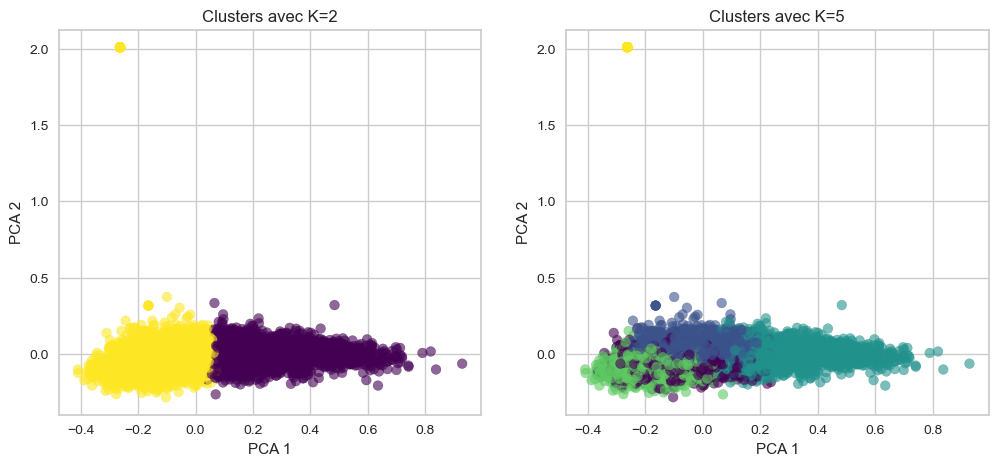

In [9]:
from sklearn.decomposition import PCA

# Réduire à 2 dimensions avec PCA
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_pca)

# Appliquer K-Means avec K=2 et K=5 pour comparer
kmeans_2 = KMeans(n_clusters=2, random_state=42)
labels_2 = kmeans_2.fit_predict(X_pca)

kmeans_5 = KMeans(n_clusters=5, random_state=42)
labels_5 = kmeans_5.fit_predict(X_pca)

# Tracer les clusters pour k=2
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_2, cmap='viridis', alpha=0.6)
plt.title("Clusters avec K=2")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Tracer les clusters pour k=5
plt.subplot(1, 2, 2)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_5, cmap='viridis', alpha=0.6)
plt.title("Clusters avec K=5")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.show()


Avant suppression : 10000 points
Après suppression : 9775 points


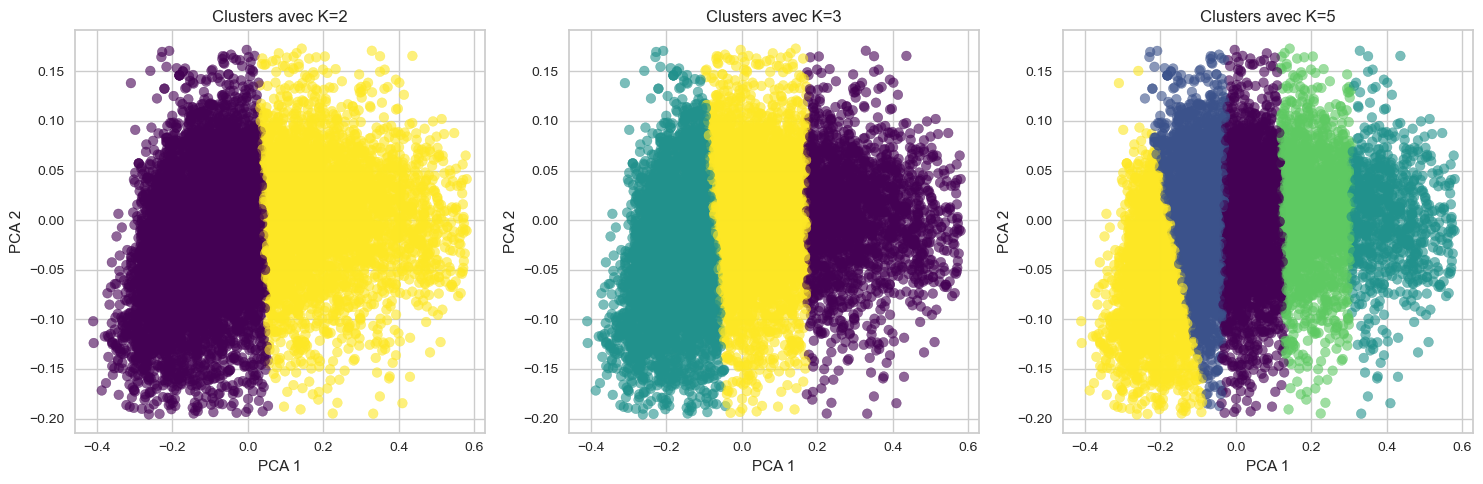

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Appliquer PCA pour réduire à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_pca)  # X_pca = tes données après prétraitement

# Détection et suppression des outliers avec IQR
Q1 = np.percentile(X_pca_2d, 25, axis=0)
Q3 = np.percentile(X_pca_2d, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = np.all((X_pca_2d >= lower_bound) & (X_pca_2d <= upper_bound), axis=1)
X_filtered = X_pca_2d[mask]

print(f"Avant suppression : {len(X_pca_2d)} points")
print(f"Après suppression : {len(X_filtered)} points")

# Visualisation des clusters pour différentes valeurs de K
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([2, 3, 5]):  # Tester K=2, 3, 5
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_filtered)
    
    axes[i].scatter(X_filtered[:, 0], X_filtered[:, 1], c=labels, cmap='viridis', alpha=0.6)
    axes[i].set_title(f"Clusters avec K={k}")
    axes[i].set_xlabel("PCA 1")
    axes[i].set_ylabel("PCA 2")

plt.tight_layout()
plt.show()


In [11]:
# from sklearn.cluster import AgglomerativeClustering

# # Appliquer AGNES (Agglomerative Clustering)
# agnes = AgglomerativeClustering(n_clusters=5, linkage='ward')  # 'ward' minimise la variance intra-cluster
# clusters_agnes = agnes.fit_predict(X_pca)

# # Tracer les clusters
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=clusters_agnes, palette="viridis", alpha=0.7)
# plt.title("Visualisation des Clusters avec PCA (AGNES)")
# plt.xlabel("PCA 1")
# plt.ylabel("PCA 2")
# plt.legend(title="Clusters")
# plt.show()


In [12]:
# from sklearn.cluster import BisectingKMeans

# # Appliquer une approche DIANA via Bisecting K-Means
# diana = BisectingKMeans(n_clusters=5, random_state=42)
# clusters_diana = diana.fit_predict(X_pca)

# # Tracer les clusters
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=clusters_diana, palette="viridis", alpha=0.7)
# plt.title("Visualisation des Clusters avec PCA (AGNES)")
# plt.xlabel("PCA 1")
# plt.ylabel("PCA 2")
# plt.legend(title="Clusters")
# plt.show()

In [13]:
# from sklearn.cluster import Birch

# # Appliquer BIRCH
# birch = Birch(n_clusters=5)  # Ajuster n_clusters selon les besoins
# clusters_birch = birch.fit_predict(X_pca)

# # Tracer les clusters
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=clusters_birch, palette="viridis", alpha=0.7)
# plt.title("Visualisation des Clusters avec PCA (AGNES)")
# plt.xlabel("PCA 1")
# plt.ylabel("PCA 2")
# plt.legend(title="Clusters")
# plt.show()

In [16]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Plage de valeurs à tester
eps_values = np.linspace(0.1, 2, 10)  # Tester de 0.1 à 2 par pas de 0.2
min_samples_values = range(5, 30, 5)  # Tester de 5 à 30 par pas de 5

best_score = -1
best_params = None
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Appliquer DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_pca)

        # Filtrer les points qui ne sont pas des outliers (-1)
        valid_clusters = clusters[clusters != -1]
        valid_X = X_pca[clusters != -1]

        # Vérifier qu'on a au moins 2 clusters valides pour calculer silhouette score
        if len(set(valid_clusters)) > 1:
            silhouette = silhouette_score(valid_X, valid_clusters)
            davies_bouldin = davies_bouldin_score(valid_X, valid_clusters)

            # Stocker les résultats
            results.append((eps, min_samples, silhouette, davies_bouldin))

            # Garder la meilleure config selon Silhouette Score
            if silhouette > best_score:
                best_score = silhouette
                best_params = (eps, min_samples)

# Trier les résultats par Silhouette Score décroissant
results.sort(key=lambda x: x[2], reverse=True)

# Afficher les 5 meilleures configurations
print("Top 5 des meilleures configurations DBSCAN :")
print("EPS\tMin Samples\tSilhouette\tDavies-Bouldin")
for res in results[:5]:
    print(f"{res[0]:.2f}\t{res[1]}\t\t{res[2]:.3f}\t\t{res[3]:.3f}")

# Afficher les meilleurs paramètres
print(f"\n✅ Meilleur DBSCAN trouvé : eps={best_params[0]:.2f}, min_samples={best_params[1]}")



Top 5 des meilleures configurations DBSCAN :
EPS	Min Samples	Silhouette	Davies-Bouldin
0.10	25		0.946		0.052
0.10	20		0.944		0.053
0.31	25		0.730		0.195
0.31	20		0.729		0.196
0.31	15		0.728		0.197

✅ Meilleur DBSCAN trouvé : eps=0.10, min_samples=25


In [17]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters_dbscan = dbscan.fit_predict(X_pca)
# Ajouter au DataFrame
df_sample["Cluster_DBSCAN"] = clusters_dbscan

print(df_sample["Cluster_DBSCAN"].value_counts())  # Voir la distribution des clusters

0    10000
Name: Cluster_DBSCAN, dtype: int64


In [ ]:
# ### OPTICS (Généralisation de DBSCAN)
# optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
# optics_clusters = optics.fit_predict(X_tfidf)

In [ ]:
# df_clusters = pd.DataFrame({
#     'clean_text': df['clean_text'],
#     'tags': df['tags'],
#     'cluster_dbscan': dbscan_clusters,
#     'cluster_optics': optics_clusters,
# })

# print(df_clusters.head())